# Challenge
The idea behind this challenge is for you to explore the dataset, build a prediction model from it and then code a Python module that serves the model. Therefore there will be two main parts:

1. Your Jupyter (IPython) notebook containing all your experiments, analyzes, and results. In this notebook, you will perform all your visualizations, data normalizations, training and evaluation of your model.
2. A complete Python module ready to be used containing the model you trained. This module should be coded as if the engineering team would use it so it must contain usage instructions and a clear interface (generally speaking) to access your model.

## The dataset
Kickstarter is one of the main online crowdfunding platforms in the world. The dataset provided contains more de 300,000 projects launched on the platform in 2018. In the `data.csv` file there are the following columns:

- **ID**: internal ID, _numeric_
- **name**: name of the project, _string_
- **category**: project's category, _string_
- **main_category**: campaign's category, _string_
- **currency**: project's currency, _string_
- **deadline**: project's deadline date, _timestamp_
- **goal**: fundraising goal, _numeric_
- **launched**: project's start date, _timestamp_
- **pledged**: amount pledged by backers (project's currency), _numeric_
- **state**: project's current state, _string_; **this is what you have to predict**
- **backers**: amount of poeple that backed the project, _numeric_
- **country**: project's country, _string_
- **usd pledged**: amount pledged by backers converted to USD (conversion made by KS), _numeric_
- **usd_pledged_real**: amount pledged by backers converted to USD (conversion made by fixer.io api), _numeric_
- **usd_goal_real**: fundraising goal is USD, _numeric_

## Goal
Your goal is to predict whether a project will be successful or not. It is entirely up to you which features you will use and which model. When it comes to performance metrics you should be able to say when the model is good enough. There are no minimum requirements or tricky conditions. What we are trying to evaluate is how you handle an unknown dataset in a classification task and your ability to deliver the results.

## Deliverables
Do not use this notebook for your submission. The expected outputs are:

1. A Jupyter (IPython) notebook (that you have to create) containing your work and explanations. This is where you will put all your experiments, notes, visualizations and transformations in the data. This is also where you will prepare your data and train your prediction model.
2. A Python module containing your model and functions to use to predict Kickstarter projects' state. Assume that in order to review your work an engineer will import this module and try to make some predictions so your model should be in it.
3. A Markdown file containing usage instructions for your Python module. 

In [51]:
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True
if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

%matplotlib inline

In [52]:
df=pd.read_csv("data.csv")
print("Table 1: Summary of Values")
df.describe()

Table 1: Summary of Values


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [53]:
df.isnull().sum()


ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [54]:
df.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [55]:
df

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


In [6]:
df.shape

(378661, 15)

In [56]:
for i in df.columns.tolist():
    if str(df[i].dtype)=='object':
        count=len(df[i].unique())
        print(f"unique items in {i} : {count}")

unique items in name : 375765
unique items in category : 159
unique items in main_category : 15
unique items in currency : 14
unique items in deadline : 3164
unique items in launched : 378089
unique items in state : 6
unique items in country : 23


In [57]:
df.category.unique()

array(['Poetry', 'Narrative Film', 'Music', 'Film & Video', 'Restaurants',
       'Food', 'Drinks', 'Product Design', 'Documentary', 'Nonfiction',
       'Indie Rock', 'Crafts', 'Games', 'Tabletop Games', 'Design',
       'Comic Books', 'Art Books', 'Fashion', 'Childrenswear', 'Theater',
       'Comics', 'DIY', 'Webseries', 'Animation', 'Food Trucks',
       'Public Art', 'Illustration', 'Photography', 'Pop', 'People',
       'Art', 'Family', 'Fiction', 'Accessories', 'Rock', 'Hardware',
       'Software', 'Weaving', 'Gadgets', 'Web', 'Jazz', 'Ready-to-wear',
       'Festivals', 'Video Games', 'Anthologies', 'Publishing', 'Shorts',
       'Electronic Music', 'Radio & Podcasts', 'Apps', 'Cookbooks',
       'Apparel', 'Metal', 'Comedy', 'Hip-Hop', 'Periodicals', 'Dance',
       'Technology', 'Painting', 'World Music', 'Photobooks', 'Drama',
       'Architecture', 'Young Adult', 'Latin', 'Mobile Games', 'Flight',
       'Fine Art', 'Action', 'Playing Cards', 'Makerspaces', 'Punk',
       

In [9]:
df=pd.read_csv("data.csv")

In [58]:
df = pd.concat([df, pd.get_dummies(df['main_category'])], axis=1)

In [59]:
df = pd.concat([df, pd.get_dummies(df['currency'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['country'])], axis=1)

In [60]:
df = pd.concat([df, pd.get_dummies(df['state'])], axis=1)
x=pd.to_datetime(df.deadline,infer_datetime_format=True)
df['Deadline(Days)']=pd.to_timedelta(x)
x=pd.to_datetime(df.launched,infer_datetime_format=True)
df['Launched(days))']=pd.to_timedelta(x)
df['Delta']=df['Deadline(Days)']-df['Launched(days))']
df['Delta']=df['Delta'].dt.total_seconds()
df['Launched(days))']=df['Launched(days))'].dt.total_seconds()
df['Deadline(Days)']=df['Deadline(Days)'].dt.total_seconds()

In [61]:
df.drop(['name','category','main_category','currency','state','country','deadline','launched'],inplace=True,axis=1)

In [62]:
df

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,Art,Comics,Crafts,...,US,canceled,failed,live,successful,suspended,undefined,Deadline(Days),Launched(days)),Delta
0,1000002330,1000.0,0.00,0,0.00,0.00,1533.95,0,0,0,...,0,0,1,0,0,0,0,1.444349e+09,1.439295e+09,5053652.0
1,1000003930,30000.0,2421.00,15,100.00,2421.00,30000.00,0,0,0,...,1,0,1,0,0,0,0,1.509494e+09,1.504327e+09,5166963.0
2,1000004038,45000.0,220.00,3,220.00,220.00,45000.00,0,0,0,...,1,0,1,0,0,0,0,1.361837e+09,1.357950e+09,3886750.0
3,1000007540,5000.0,1.00,1,1.00,1.00,5000.00,0,0,0,...,1,0,1,0,0,0,0,1.334534e+09,1.331955e+09,2579749.0
4,1000011046,19500.0,1283.00,14,1283.00,1283.00,19500.00,0,0,0,...,1,1,0,0,0,0,0,1.440806e+09,1.435999e+09,4807497.0
5,1000014025,50000.0,52375.00,224,52375.00,52375.00,50000.00,0,0,0,...,1,0,0,0,1,0,0,1.459469e+09,1.456494e+09,2974893.0
6,1000023410,1000.0,1205.00,16,1205.00,1205.00,1000.00,0,0,0,...,1,0,0,0,1,0,0,1.419120e+09,1.417459e+09,1661356.0
7,1000030581,25000.0,453.00,40,453.00,453.00,25000.00,0,0,0,...,1,0,1,0,0,0,0,1.458173e+09,1.454357e+09,3815688.0
8,1000034518,125000.0,8233.00,58,8233.00,8233.00,125000.00,0,0,0,...,1,1,0,0,0,0,0,1.401322e+09,1.398363e+09,2958317.0
9,100004195,65000.0,6240.57,43,6240.57,6240.57,65000.00,0,0,0,...,1,1,0,0,0,0,0,1.407629e+09,1.405116e+09,2513052.0


In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
rf=RandomForestClassifier(n_estimators=10,criterion='entropy',n_jobs=-1)
rf_Kfold=KFold(n_splits=3)

In [64]:
states=["canceled","failed","live","successful","suspended","undefined"]
y=df[states]
x=df.drop(states,axis=1)

In [65]:
df.drop(states,axis=1)

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,Art,Comics,Crafts,...,"N,0""",NL,NO,NZ,SE,SG,US,Deadline(Days),Launched(days)),Delta
0,1000002330,1000.0,0.00,0,0.00,0.00,1533.95,0,0,0,...,0,0,0,0,0,0,0,1.444349e+09,1.439295e+09,5053652.0
1,1000003930,30000.0,2421.00,15,100.00,2421.00,30000.00,0,0,0,...,0,0,0,0,0,0,1,1.509494e+09,1.504327e+09,5166963.0
2,1000004038,45000.0,220.00,3,220.00,220.00,45000.00,0,0,0,...,0,0,0,0,0,0,1,1.361837e+09,1.357950e+09,3886750.0
3,1000007540,5000.0,1.00,1,1.00,1.00,5000.00,0,0,0,...,0,0,0,0,0,0,1,1.334534e+09,1.331955e+09,2579749.0
4,1000011046,19500.0,1283.00,14,1283.00,1283.00,19500.00,0,0,0,...,0,0,0,0,0,0,1,1.440806e+09,1.435999e+09,4807497.0
5,1000014025,50000.0,52375.00,224,52375.00,52375.00,50000.00,0,0,0,...,0,0,0,0,0,0,1,1.459469e+09,1.456494e+09,2974893.0
6,1000023410,1000.0,1205.00,16,1205.00,1205.00,1000.00,0,0,0,...,0,0,0,0,0,0,1,1.419120e+09,1.417459e+09,1661356.0
7,1000030581,25000.0,453.00,40,453.00,453.00,25000.00,0,0,0,...,0,0,0,0,0,0,1,1.458173e+09,1.454357e+09,3815688.0
8,1000034518,125000.0,8233.00,58,8233.00,8233.00,125000.00,0,0,0,...,0,0,0,0,0,0,1,1.401322e+09,1.398363e+09,2958317.0
9,100004195,65000.0,6240.57,43,6240.57,6240.57,65000.00,0,0,0,...,0,0,0,0,0,0,1,1.407629e+09,1.405116e+09,2513052.0


In [17]:
x.dtypes

ID                    int64
goal                float64
pledged             float64
backers               int64
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
Art                   uint8
Comics                uint8
Crafts                uint8
Dance                 uint8
Design                uint8
Fashion               uint8
Film & Video          uint8
Food                  uint8
Games                 uint8
Journalism            uint8
Music                 uint8
Photography           uint8
Publishing            uint8
Technology            uint8
Theater               uint8
AUD                   uint8
CAD                   uint8
CHF                   uint8
DKK                   uint8
EUR                   uint8
GBP                   uint8
HKD                   uint8
JPY                   uint8
                     ...   
NZD                   uint8
SEK                   uint8
SGD                   uint8
USD                   uint8
AT                  

In [66]:
y

,canceled,failed,live,successful,suspended,undefined
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,1,0,0,0,0,0
5,0,0,0,1,0,0
6,0,0,0,1,0,0
7,0,1,0,0,0,0
8,1,0,0,0,0,0
9,1,0,0,0,0,0


In [69]:
rf_oof_predict=np.zeros([x.shape[0],6])
rf_oof_predict

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [67]:
x=x.fillna(0)

In [70]:
#rf_oof_predict=np.zeros(x.shape[0])
for train_idx, test_idx in rf_Kfold.split(x):
    rf.fit(x.loc[train_idx],y.loc[train_idx])
    rf_oof_predict[test_idx]=rf.predict(x.loc[test_idx])
    print(classification_report(y.loc[test_idx],rf_oof_predict[test_idx]))

             precision    recall  f1-score   support

          0       0.31      0.04      0.07     12898
          1       0.84      0.94      0.89     65579
          2       0.93      0.93      0.93       940
          3       0.99      1.00      0.99     45031
          4       0.00      0.00      0.00       599
          5       1.00      0.99      1.00      1174

avg / total       0.84      0.86      0.84    126221

             precision    recall  f1-score   support

          0       0.30      0.04      0.07     12957
          1       0.84      0.92      0.88     65977
          2       0.92      0.93      0.93       922
          3       0.99      0.99      0.99     44556
          4       0.00      0.00      0.00       608
          5       0.99      1.00      1.00      1200

avg / total       0.84      0.85      0.83    126220

             precision    recall  f1-score   support

          0       0.30      0.04      0.06     12924
          1       0.84      0.94      0

array(['failed', 'failed', 'failed', ..., 'successful', 'failed',
       'failed'], dtype=object)

In [21]:
print(classification_report(y,rf_oof_predict))

             precision    recall  f1-score   support

          0       0.31      0.04      0.07     38779
          1       0.84      0.93      0.89    197719
          2       0.92      0.92      0.92      2799
          3       0.99      1.00      0.99    133956
          4       0.21      0.00      0.00      1846
          5       1.00      1.00      1.00      3562

avg / total       0.84      0.86      0.84    378661



In [71]:
pred=np.einsum('i,...i',np.array([0,1,2,3,4,5]),rf_oof_predict)
truth=np.einsum('i,...i',np.array([0,1,2,3,4,5]),y)

In [73]:
pred[0:20]

array([1., 1., 1., 1., 1., 3., 3., 1., 1., 1., 1., 3., 1., 1., 3., 1., 1.,
       1., 3., 1.])

In [74]:
truth[0:20]

array([1, 1, 1, 1, 0, 3, 3, 1, 0, 0, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1])

Confusion matrix, without normalization
[[  4717  33005    187    868      0      2]
 [ 12907 184090      2    701      9     10]
 [   197     12   2575     15      0      0]
 [   526     36      5 133383      0      6]
 [   258   1270     16    300      2      0]
 [     7      1      0      1      0   3553]]
Normalized confusion matrix
[[1.22e-01 8.51e-01 4.82e-03 2.24e-02 0.00e+00 5.16e-05]
 [6.53e-02 9.31e-01 1.01e-05 3.55e-03 4.55e-05 5.06e-05]
 [7.04e-02 4.29e-03 9.20e-01 5.36e-03 0.00e+00 0.00e+00]
 [3.93e-03 2.69e-04 3.73e-05 9.96e-01 0.00e+00 4.48e-05]
 [1.40e-01 6.88e-01 8.67e-03 1.63e-01 1.08e-03 0.00e+00]
 [1.97e-03 2.81e-04 0.00e+00 2.81e-04 0.00e+00 9.97e-01]]


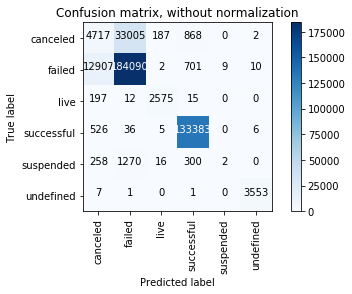

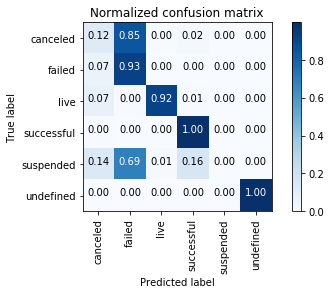

In [75]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
class_names=['canceled','failed','live','successful','suspended','undefined']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(truth, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [76]:
import xgboost as xgb

In [78]:
truth[0:20]

array([1, 1, 1, 1, 0, 3, 3, 1, 0, 0, 1, 3, 1, 1, 3, 1, 1, 1, 3, 1])

In [79]:
dtrain = xgb.DMatrix(x, label=truth)
from xgboost import XGBClassifier

In [80]:
params=dict()
params['min_child_weight'] = 0.95
params['cosample_bytree'] = 0.95
params['subsample'] = 1
params['gamma'] = 1
params['eta'] = 0.01
params['reg_lambda']=1
params['objective'] = 'multi:softprob'
params['num_class']=6
params['silent']=0
x_class=XGBClassifier(**params, n_estimators=10,eval_metric=['merror','mlogloss'], verbose_eval=2)


In [81]:
x_class.fit(x,truth )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, cosample_bytree=0.95, eta=0.01,
       eval_metric=['merror', 'mlogloss'], gamma=1, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=0.95, missing=None,
       n_estimators=10, n_jobs=1, nthread=None, num_class=6,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=0, subsample=1,
       verbose_eval=2)

In [82]:
num_rounds=10
n_folds=3
xgb.cv(params,dtrain, num_rounds, n_folds,[(dtrain,'train')], early_stopping_rounds=10,verbose_eval=2)

[0]	train-merror:0.121515+0.00103582	test-merror:0.122094+0.00143779
[2]	train-merror:0.121284+0.00105712	test-merror:0.121922+0.00084922
[4]	train-merror:0.120711+0.000677508	test-merror:0.12123+0.000632157
[6]	train-merror:0.119295+0.00105642	test-merror:0.11983+0.0012629
[8]	train-merror:0.119161+0.00101416	test-merror:0.119717+0.00125547
[9]	train-merror:0.119233+0.00094388	test-merror:0.119753+0.00121154


,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.121515,0.001036,0.122094,0.001438
1,0.121545,0.000931,0.122086,0.000916
2,0.121284,0.001057,0.121922,0.000849
3,0.120753,0.000654,0.121272,0.000703
4,0.120711,0.000678,0.121230,0.000632
5,0.119406,0.001003,0.119920,0.001276
6,0.119295,0.001056,0.119830,0.001263
7,0.119052,0.000935,0.119656,0.001173
8,0.119161,0.001014,0.119717,0.001255
9,0.119233,0.000944,0.119753,0.001212


In [43]:
xgb.train(params,dtrain,10,[(dtrain,'train')], early_stopping_rounds=10,verbose_eval=5)

[0]	train-merror:0.120192
Will train until train-merror hasn't improved in 10 rounds.
[5]	train-merror:0.120773
[9]	train-merror:0.120232


In [21]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(x,truth), verbose=3, random_state=1001 )

# Here we go

random_search.fit(x, truth)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
c:\programdata\miniconda3\lib\runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
c:\programdata\miniconda3\lib\runpy.py in _run_code(code=<code object <module> at 0x0000017F345C74B0, fil...lib\site-packages\ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\programdata\miniconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\programd...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x0000017F345C74B0, fil...lib\site-packages\ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': r'c:\programdata\miniconda3\lib\site-packages\__pycache__\ipykernel_launcher.cpython-36.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': r'c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...nda3\\lib\\site-packages\\ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from 'c:\\programd...a3\\lib\\site-packages\\ipykernel\\kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
c:\programdata\miniconda3\lib\site-packages\traitlets\config\application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
c:\programdata\miniconda3\lib\site-packages\ipykernel\kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    481         if self.poller is not None:
    482             self.poller.start()
    483         self.kernel.start()
    484         self.io_loop = ioloop.IOLoop.current()
    485         try:
--> 486             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    487         except KeyboardInterrupt:
    488             pass
    489 
    490 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
c:\programdata\miniconda3\lib\site-packages\tornado\platform\asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    122         except (RuntimeError, AssertionError):
    123             old_loop = None
    124         try:
    125             self._setup_logging()
    126             asyncio.set_event_loop(self.asyncio_loop)
--> 127             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Win...EventLoop running=True closed=False debug=False>>
    128         finally:
    129             asyncio.set_event_loop(old_loop)
    130 
    131     def stop(self):

...........................................................................
c:\programdata\miniconda3\lib\asyncio\base_events.py in run_forever(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
    417             sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    418                                    finalizer=self._asyncgen_finalizer_hook)
    419         try:
    420             events._set_running_loop(self)
    421             while True:
--> 422                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_Windo...EventLoop running=True closed=False debug=False>>
    423                 if self._stopping:
    424                     break
    425         finally:
    426             self._stopping = False

...........................................................................
c:\programdata\miniconda3\lib\asyncio\base_events.py in _run_once(self=<_WindowsSelectorEventLoop running=True closed=False debug=False>)
   1427                         logger.warning('Executing %s took %.3f seconds',
   1428                                        _format_handle(handle), dt)
   1429                 finally:
   1430                     self._current_handle = None
   1431             else:
-> 1432                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(852, 1)>>
   1433         handle = None  # Needed to break cycles when an exception occurs.
   1434 
   1435     def _set_coroutine_wrapper(self, enabled):
   1436         try:

...........................................................................
c:\programdata\miniconda3\lib\asyncio\events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(852, 1)>)
    140             self._callback = None
    141             self._args = None
    142 
    143     def _run(self):
    144         try:
--> 145             self._callback(*self._args)
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (852, 1)
    146         except Exception as exc:
    147             cb = _format_callback_source(self._callback, self._args)
    148             msg = 'Exception in callback {}'.format(cb)
    149             context = {

...........................................................................
c:\programdata\miniconda3\lib\site-packages\tornado\platform\asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=852, events=1)
    112             self.writers.remove(fd)
    113         del self.handlers[fd]
    114 
    115     def _handle_events(self, fd, events):
    116         fileobj, handler_func = self.handlers[fd]
--> 117         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    118 
    119     def start(self):
    120         try:
    121             old_loop = asyncio.get_event_loop()

...........................................................................
c:\programdata\miniconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
c:\programdata\miniconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
c:\programdata\miniconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
c:\programdata\miniconda3\lib\site-packages\zmq\eventloop\zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
c:\programdata\miniconda3\lib\site-packages\tornado\stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    271         # Fast path when there are no active contexts.
    272         def null_wrapper(*args, **kwargs):
    273             try:
    274                 current_state = _state.contexts
    275                 _state.contexts = cap_contexts[0]
--> 276                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    277             finally:
    278                 _state.contexts = current_state
    279         null_wrapper._wrapped = True
    280         return null_wrapper

...........................................................................
c:\programdata\miniconda3\lib\site-packages\ipykernel\kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
c:\programdata\miniconda3\lib\site-packages\ipykernel\kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'folds = 3\nparam_comb = 5\n\nskf = StratifiedKFold(...1001 )\n\n# Here we go\n\nrandom_search.fit(x, truth)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 8, 21, 0, 35, 47, 456915, tzinfo=tzutc()), 'msg_id': 'a82d133965b243f2be6e8b16eb3edfb3', 'msg_type': 'execute_request', 'session': '2ecad5f699e14556a71979e89bbcbc4a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'a82d133965b243f2be6e8b16eb3edfb3', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warn("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'2ecad5f699e14556a71979e89bbcbc4a']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'folds = 3\nparam_comb = 5\n\nskf = StratifiedKFold(...1001 )\n\n# Here we go\n\nrandom_search.fit(x, truth)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 8, 21, 0, 35, 47, 456915, tzinfo=tzutc()), 'msg_id': 'a82d133965b243f2be6e8b16eb3edfb3', 'msg_type': 'execute_request', 'session': '2ecad5f699e14556a71979e89bbcbc4a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'a82d133965b243f2be6e8b16eb3edfb3', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
c:\programdata\miniconda3\lib\site-packages\ipykernel\kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'2ecad5f699e14556a71979e89bbcbc4a'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'folds = 3\nparam_comb = 5\n\nskf = StratifiedKFold(...1001 )\n\n# Here we go\n\nrandom_search.fit(x, truth)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 8, 21, 0, 35, 47, 456915, tzinfo=tzutc()), 'msg_id': 'a82d133965b243f2be6e8b16eb3edfb3', 'msg_type': 'execute_request', 'session': '2ecad5f699e14556a71979e89bbcbc4a', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'a82d133965b243f2be6e8b16eb3edfb3', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
c:\programdata\miniconda3\lib\site-packages\ipykernel\ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='folds = 3\nparam_comb = 5\n\nskf = StratifiedKFold(...1001 )\n\n# Here we go\n\nrandom_search.fit(x, truth)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'folds = 3\nparam_comb = 5\n\nskf = StratifiedKFold(...1001 )\n\n# Here we go\n\nrandom_search.fit(x, truth)'
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
c:\programdata\miniconda3\lib\site-packages\ipykernel\zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('folds = 3\nparam_comb = 5\n\nskf = StratifiedKFold(...1001 )\n\n# Here we go\n\nrandom_search.fit(x, truth)',), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('folds = 3\nparam_comb = 5\n\nskf = StratifiedKFold(...1001 )\n\n# Here we go\n\nrandom_search.fit(x, truth)',)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
c:\programdata\miniconda3\lib\site-packages\IPython\core\interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='folds = 3\nparam_comb = 5\n\nskf = StratifiedKFold(...1001 )\n\n# Here we go\n\nrandom_search.fit(x, truth)', store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = 'folds = 3\nparam_comb = 5\n\nskf = StratifiedKFold(...1001 )\n\n# Here we go\n\nrandom_search.fit(x, truth)'
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
c:\programdata\miniconda3\lib\site-packages\IPython\core\interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='folds = 3\nparam_comb = 5\n\nskf = StratifiedKFold(...1001 )\n\n# Here we go\n\nrandom_search.fit(x, truth)', store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
c:\programdata\miniconda3\lib\site-packages\IPython\core\interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-21-033d48d2dcf7>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 17f425c0438, executio...rue silent=False shell_futures=True> result=None>)
   2904                     return True
   2905 
   2906             for i, node in enumerate(to_run_interactive):
   2907                 mod = ast.Interactive([node])
   2908                 code = compiler(mod, cell_name, "single")
-> 2909                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x0000017F5086ED20, file "<ipython-input-21-033d48d2dcf7>", line 10>
        result = <ExecutionResult object at 17f425c0438, executio...rue silent=False shell_futures=True> result=None>
   2910                     return True
   2911 
   2912             # Flush softspace
   2913             if softspace(sys.stdout, 0):

...........................................................................
c:\programdata\miniconda3\lib\site-packages\IPython\core\interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x0000017F5086ED20, file "<ipython-input-21-033d48d2dcf7>", line 10>, result=<ExecutionResult object at 17f425c0438, executio...rue silent=False shell_futures=True> result=None>)
   2958         outflag = True  # happens in more places, so it's easier as default
   2959         try:
   2960             try:
   2961                 self.hooks.pre_run_code_hook()
   2962                 #rprint('Running code', repr(code_obj)) # dbg
-> 2963                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x0000017F5086ED20, file "<ipython-input-21-033d48d2dcf7>", line 10>
        self.user_global_ns = {'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import sys\ntry:\n    sys.getwindowsversion()\nexce..._ipython().run_line_magic('matplotlib', 'inline')", 'df=pd.read_csv("data.csv")\nprint("Table 1: Summary of Values")\ndf.describe()', 'df.isnull().sum()', 'df.dtypes', 'df', 'df.shape', 'for i in df.columns.tolist():\n    if str(df[i].d...)\n        print(f"unique items in {i} : {count}")', 'df.category.unique()', 'df=pd.read_csv("data.csv")', "df = pd.concat([df, pd.get_dummies(df['main_category'])], axis=1)", "df = pd.concat([df, pd.get_dummies(df['currency'...ncat([df, pd.get_dummies(df['country'])], axis=1)", "df = pd.concat([df, pd.get_dummies(df['state'])]...e(Days)']=df['Deadline(Days)'].dt.total_seconds()", "df.drop(['name','category','main_category','curr...ntry','deadline','launched'],inplace=True,axis=1)", 'df', 'x.dtypes', 'states=["canceled","failed","live","successful",...undefined"]\ny=df[states]\nx=df.drop(states,axis=1)', 'x.dtypes', "pred=np.einsum('i,...i',np.array([0,1,2,3,4,5]),...uth=np.einsum('i,...i',np.array([0,1,2,3,4,5]),y)", "#pred=np.einsum('i,...i',np.array([0,1,2,3,4,5])...uth=np.einsum('i,...i',np.array([0,1,2,3,4,5]),y)", ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'Out': {2:                  ID          goal       pledged ...00e+04  
max        2.033899e+07   1.663614e+08  , 3: ID                     0
name                   ...eal       0
usd_goal_real          0
dtype: int64, 4: ID                    int64
name                ...float64
usd_goal_real       float64
dtype: object, 5:                 ID                              ...4.00        2000.00  

[378661 rows x 15 columns], 6: (378661, 15), 8: array(['Poetry', 'Narrative Film', 'Music', 'Fil... 'Chiptune',
       'Residencies'], dtype=object), 14:                 ID      goal   pledged  backers ...1066e+09  2386333.0  

[378661 rows x 68 columns], 15: dtype('<M8[ns]'), 17: ID                    int64
goal                ...a               float64
Length: 62, dtype: object}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'XGBClassifier': <class 'xgboost.sklearn.XGBClassifier'>, ...}
        self.user_ns = {'DecisionTreeClassifier': <class 'sklearn.tree.tree.DecisionTreeClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', "import sys\ntry:\n    sys.getwindowsversion()\nexce..._ipython().run_line_magic('matplotlib', 'inline')", 'df=pd.read_csv("data.csv")\nprint("Table 1: Summary of Values")\ndf.describe()', 'df.isnull().sum()', 'df.dtypes', 'df', 'df.shape', 'for i in df.columns.tolist():\n    if str(df[i].d...)\n        print(f"unique items in {i} : {count}")', 'df.category.unique()', 'df=pd.read_csv("data.csv")', "df = pd.concat([df, pd.get_dummies(df['main_category'])], axis=1)", "df = pd.concat([df, pd.get_dummies(df['currency'...ncat([df, pd.get_dummies(df['country'])], axis=1)", "df = pd.concat([df, pd.get_dummies(df['state'])]...e(Days)']=df['Deadline(Days)'].dt.total_seconds()", "df.drop(['name','category','main_category','curr...ntry','deadline','launched'],inplace=True,axis=1)", 'df', 'x.dtypes', 'states=["canceled","failed","live","successful",...undefined"]\ny=df[states]\nx=df.drop(states,axis=1)', 'x.dtypes', "pred=np.einsum('i,...i',np.array([0,1,2,3,4,5]),...uth=np.einsum('i,...i',np.array([0,1,2,3,4,5]),y)", "#pred=np.einsum('i,...i',np.array([0,1,2,3,4,5])...uth=np.einsum('i,...i',np.array([0,1,2,3,4,5]),y)", ...], 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'MinMaxScaler': <class 'sklearn.preprocessing.data.MinMaxScaler'>, 'Out': {2:                  ID          goal       pledged ...00e+04  
max        2.033899e+07   1.663614e+08  , 3: ID                     0
name                   ...eal       0
usd_goal_real          0
dtype: int64, 4: ID                    int64
name                ...float64
usd_goal_real       float64
dtype: object, 5:                 ID                              ...4.00        2000.00  

[378661 rows x 15 columns], 6: (378661, 15), 8: array(['Poetry', 'Narrative Film', 'Music', 'Fil... 'Chiptune',
       'Residencies'], dtype=object), 14:                 ID      goal   pledged  backers ...1066e+09  2386333.0  

[378661 rows x 68 columns], 15: dtype('<M8[ns]'), 17: ID                    int64
goal                ...a               float64
Length: 62, dtype: object}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'RandomizedSearchCV': <class 'sklearn.model_selection._search.RandomizedSearchCV'>, 'StratifiedKFold': <class 'sklearn.model_selection._split.StratifiedKFold'>, 'XGBClassifier': <class 'xgboost.sklearn.XGBClassifier'>, ...}
   2964             finally:
   2965                 # Reset our crash handler in place
   2966                 sys.excepthook = old_excepthook
   2967         except SystemExit as e:

...........................................................................
C:\Users\Robert\Downloads\kickstarter-dataset-master (1)\<ipython-input-21-033d48d2dcf7> in <module>()
      5 
      6 random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(x,truth), verbose=3, random_state=1001 )
      7 
      8 # Here we go
      9 
---> 10 random_search.fit(x, truth)

...........................................................................
c:\programdata\miniconda3\lib\site-packages\sklearn\model_selection\_search.py in fit(self=RandomizedSearchCV(cv=<generator object _BaseKFo...train_score='warn', scoring='roc_auc', verbose=3), X=                ID      goal   pledged  backers ...1066e+09  2386333.0  

[378661 rows x 62 columns], y=array([1, 1, 1, ..., 1, 1, 1]), groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method _CVIterableWrapper.split of _CVIte... array([     1,      6, ..., 378658, 378660]))])>
        X =                 ID      goal   pledged  backers ...1066e+09  2386333.0  

[378661 rows x 62 columns]
        y = array([1, 1, 1, ..., 1, 1, 1])
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
c:\programdata\miniconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=Parallel(n_jobs=4), iterable=<generator object BaseSearchCV.fit.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=4)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Mon Aug 20 19:36:57 2018
PID: 2036                Python 3.6.5: c:\programdata\miniconda3\python.exe
...........................................................................
c:\programdata\miniconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=1.0),                 ID      goal    ...      Launche...311066e+09  2386333.0

[378661 rows x 62 columns], memmap([1, 1, 1, ..., 1, 1, 1]), {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([     1,      3,      4, ..., 378658, 378659, 378660]), array([     0,      2,      5, ..., 378654, 378655, 378657]), 3, {'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\programdata\miniconda3\lib\site-packages\sklearn\externals\joblib\parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=1.0),                 ID      goal    ...      Launche...311066e+09  2386333.0

[378661 rows x 62 columns], memmap([1, 1, 1, ..., 1, 1, 1]), {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([     1,      3,      4, ..., 378658, 378659, 378660]), array([     0,      2,      5, ..., 378654, 378655, 378657]), 3, {'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
c:\programdata\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py in _fit_and_score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=1.0), X=                ID      goal    ...      Launche...311066e+09  2386333.0

[378661 rows x 62 columns], y=memmap([1, 1, 1, ..., 1, 1, 1]), scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([     1,      3,      4, ..., 378658, 378659, 378660]), test=array([     0,      2,      5, ..., 378654, 378655, 378657]), verbose=3, parameters={'colsample_bytree': 1.0, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    483                              " make sure that it has been spelled correctly.)")
    484 
    485     else:
    486         fit_time = time.time() - start_time
    487         # _score will return dict if is_multimetric is True
--> 488         test_scores = _score(estimator, X_test, y_test, scorer, is_multimetric)
        test_scores = {}
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=1.0)
        X_test =                 ID     goal    ...      Launched...308714e+09  2319886.0

[126223 rows x 62 columns]
        y_test = memmap([1, 1, 3, ..., 1, 0, 1])
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
        is_multimetric = True
    489         score_time = time.time() - start_time - fit_time
    490         if return_train_score:
    491             train_scores = _score(estimator, X_train, y_train, scorer,
    492                                   is_multimetric)

...........................................................................
c:\programdata\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py in _score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=1.0), X_test=                ID     goal    ...      Launched...308714e+09  2319886.0

[126223 rows x 62 columns], y_test=memmap([1, 1, 3, ..., 1, 0, 1]), scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, is_multimetric=True)
    518 
    519     Will return a single float if is_multimetric is False and a dict of floats,
    520     if is_multimetric is True
    521     """
    522     if is_multimetric:
--> 523         return _multimetric_score(estimator, X_test, y_test, scorer)
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=1.0)
        X_test =                 ID     goal    ...      Launched...308714e+09  2319886.0

[126223 rows x 62 columns]
        y_test = memmap([1, 1, 3, ..., 1, 0, 1])
        scorer = {'score': make_scorer(roc_auc_score, needs_threshold=True)}
    524     else:
    525         if y_test is None:
    526             score = scorer(estimator, X_test)
    527         else:

...........................................................................
c:\programdata\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py in _multimetric_score(estimator=XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=1.0), X_test=                ID     goal    ...      Launched...308714e+09  2319886.0

[126223 rows x 62 columns], y_test=memmap([1, 1, 3, ..., 1, 0, 1]), scorers={'score': make_scorer(roc_auc_score, needs_threshold=True)})
    548 
    549     for name, scorer in scorers.items():
    550         if y_test is None:
    551             score = scorer(estimator, X_test)
    552         else:
--> 553             score = scorer(estimator, X_test, y_test)
        score = undefined
        scorer = make_scorer(roc_auc_score, needs_threshold=True)
        estimator = XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=1.0)
        X_test =                 ID     goal    ...      Launched...308714e+09  2319886.0

[126223 rows x 62 columns]
        y_test = memmap([1, 1, 3, ..., 1, 0, 1])
    554 
    555         if hasattr(score, 'item'):
    556             try:
    557                 # e.g. unwrap memmapped scalars

...........................................................................
c:\programdata\miniconda3\lib\site-packages\sklearn\metrics\scorer.py in __call__(self=make_scorer(roc_auc_score, needs_threshold=True), clf=XGBClassifier(base_score=0.5, booster='gbtree', ...=1, seed=None,
       silent=True, subsample=1.0), X=                ID     goal    ...      Launched...308714e+09  2319886.0

[126223 rows x 62 columns], y=memmap([1, 1, 3, ..., 1, 0, 1]), sample_weight=None)
    176         """
    177         super(_ThresholdScorer, self).__call__(clf, X, y,
    178                                                sample_weight=sample_weight)
    179         y_type = type_of_target(y)
    180         if y_type not in ("binary", "multilabel-indicator"):
--> 181             raise ValueError("{0} format is not supported".format(y_type))
        y_type = 'multiclass'
    182 
    183         if is_regressor(clf):
    184             y_pred = clf.predict(X)
    185         else:

ValueError: multiclass format is not supported
___________________________________________________________________________

In [43]:
**params

SyntaxError: invalid syntax (<ipython-input-43-84e53b348761>, line 1)